<a href="https://colab.research.google.com/github/samueleborgognoni/kmeans_nn_ILF_london_smart_meters/blob/main/4_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAOD FORECASTING with KMEANS-NN methodology

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [4]:
from google.colab import drive
drive.mount('/content/drive') # <- activate to use Google Colab

drive_folder_path = '/content/drive/MyDrive/-Career📚/_UNIVERSITY/__Macchine_ed_azionamenti_elettrici/_Progetto_MAE/mae_proj/'

Mounted at /content/drive


In [5]:
# Import normalized dataset with extracted features for each household + cluster_id
# 750 households | 21features

df_ID = pd.read_csv(drive_folder_path + 'data/df_extracted_norm_clusters.csv')
print(df_ID.shape)

# Display the header of df
df_ID.head(5)


(750, 21)


,LCLid,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,...,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N,cluster
0,MAC000002,0.092808,0.119064,0.119091,0.092730,0.092748,0.106704,0.115783,0.116458,0.110815,...,0.129685,0.136349,0.133041,0.113841,0.101038,0.058083,0.139120,0.134053,0.108316,5
1,MAC000005,0.044275,0.044815,0.044814,0.044193,0.044212,0.047150,0.043271,0.043760,0.040864,...,0.046777,0.048089,0.047438,0.043839,0.056807,0.033419,0.053597,0.043171,0.027675,0
2,MAC000017,0.079150,0.062699,0.062711,0.079071,0.079089,0.058711,0.054760,0.066287,0.060508,...,0.065469,0.070808,0.068158,0.060662,0.069390,0.041732,0.067978,0.070293,0.046751,0
3,MAC000026,0.154388,0.122669,0.122716,0.154316,0.154332,0.145715,0.139435,0.146693,0.133019,...,0.084117,0.096136,0.090169,0.134817,0.101975,0.118212,0.098477,0.165218,0.100686,2
4,MAC000030,0.141243,0.112202,0.112246,0.141169,0.141186,0.110712,0.084389,0.094108,0.096926,...,0.135740,0.176306,0.156168,0.095785,0.144518,0.077225,0.124258,0.126159,0.069790,5


In [6]:
def get_df_hourly(df:pd.DataFrame):
  '''Create a new pd.DataFrame with the energy measurementents
  resampled every hour'''
  # Convert timestamps from str to datetime
  df['tstp'] = pd.to_datetime(df['tstp'])
  # Resample the df
  df_hourly = (
      df
      .set_index('tstp')
      .groupby('LCLid')
      .resample('1h')['energy(kWh/hh)']
      .sum()
      .reset_index()
  )
  return df_hourly.rename(columns={'energy(kWh/hh)': 'energy(kWh)'})

# Import the time series dataset and resample it into hourly
df_time = get_df_hourly(pd.read_csv(drive_folder_path + 'data/df_cleaned.csv'))

df_time

,LCLid,tstp,energy(kWh)
0,MAC000002,2012-10-12 00:00:00,0.0
1,MAC000002,2012-10-12 01:00:00,0.0
2,MAC000002,2012-10-12 02:00:00,0.0
3,MAC000002,2012-10-12 03:00:00,0.0
4,MAC000002,2012-10-12 04:00:00,0.0
...,...,...,...
11224948,MAC005565,2012-12-19 08:00:00,0.0
11224949,MAC005565,2012-12-19 09:00:00,0.0
11224950,MAC005565,2012-12-19 10:00:00,0.0
11224951,MAC005565,2012-12-19 11:00:00,0.0


### Prepare the time dataframe for the cluster load forecasting

In [7]:
# Create a list with 10 random int
df_time_clusterID = df_time.merge(df_ID[['LCLid', 'cluster']], on='LCLid', how='left')

# Display 10 rand samples to check the cluster ID
l = np.random.randint(0, len(df_time_clusterID), 10).tolist()
df_time_clusterID.iloc[l]


,LCLid,tstp,energy(kWh),cluster
9296305,MAC004988,2012-04-17 12:00:00,0.770,5
7836759,MAC004287,2013-10-04 06:00:00,0.168,5
4900513,MAC002656,2013-04-08 00:00:00,0.307,0
7217984,MAC003851,2013-01-07 18:00:00,1.076,5
3122286,MAC001928,2013-03-26 01:00:00,1.115,0
7586228,MAC004091,2013-08-03 17:00:00,0.206,2
7093939,MAC003782,2013-09-17 19:00:00,0.814,5
520261,MAC000299,2013-01-29 21:00:00,0.511,2
928005,MAC000487,2013-10-18 22:00:00,0.365,5
3852603,MAC002358,2013-12-09 06:00:00,0.249,5


In [8]:
# Group hourly samples based on the cluster ID + calc the mean
df_time_mean_cluster = (
    df_time_clusterID
    .groupby(['cluster', 'tstp'])['energy(kWh)']
    .mean()
    .reset_index()
)
# df_time_mean_cluster.to_csv(drive_folder_path + 'data/df_time_mean_cluster.csv') <-- uncomment to save .csv
df_time_mean_cluster

,cluster,tstp,energy(kWh)
0,0,2011-12-06 15:00:00,0.127000
1,0,2011-12-06 16:00:00,0.137000
2,0,2011-12-06 17:00:00,0.540000
3,0,2011-12-06 18:00:00,0.361000
4,0,2011-12-06 19:00:00,0.400000
...,...,...,...
115581,5,2014-02-27 20:00:00,0.886685
115582,5,2014-02-27 21:00:00,0.787728
115583,5,2014-02-27 22:00:00,0.743634
115584,5,2014-02-27 23:00:00,0.595244


### Analyse autocorrelation

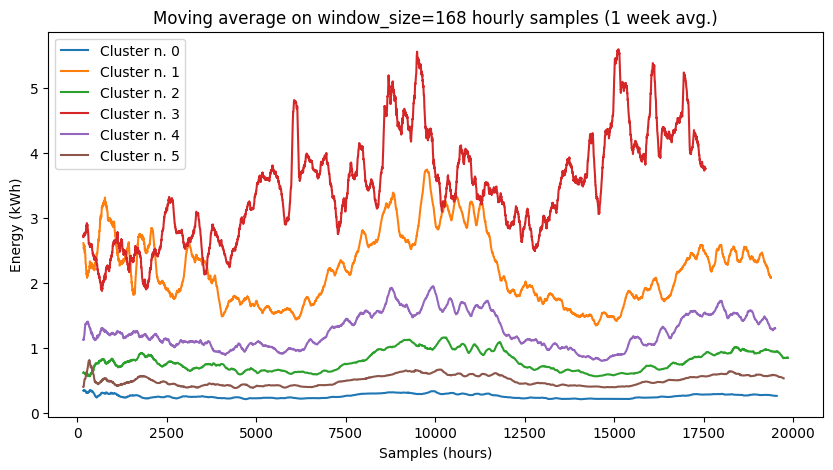

In [9]:
# PLOT THE MOVING AVERAGE FOR EACH CLUSTER TO SHOW THE NON-STATIONARITY

window_size = 24*7 # hrs in 1 week

plt.figure(figsize=(10,5))

for _cluster_id in range(max(df_time_mean_cluster['cluster']) + 1):
  # _cluster_id = 1
  __df = df_time_mean_cluster[df_time_mean_cluster['cluster'] == _cluster_id]

  # Rolling mean e rolling std
  rolling_mean = __df['energy(kWh)'].rolling(window=window_size).mean()
  plt.plot(range(0,len(__df)),rolling_mean, label=f'Cluster n. {_cluster_id}')

plt.title(f'Moving average on window_size={window_size} hourly samples (1 week avg.)')
plt.ylabel('Energy (kWh)')
plt.xlabel('Samples (hours)')
plt.legend()
plt.show()

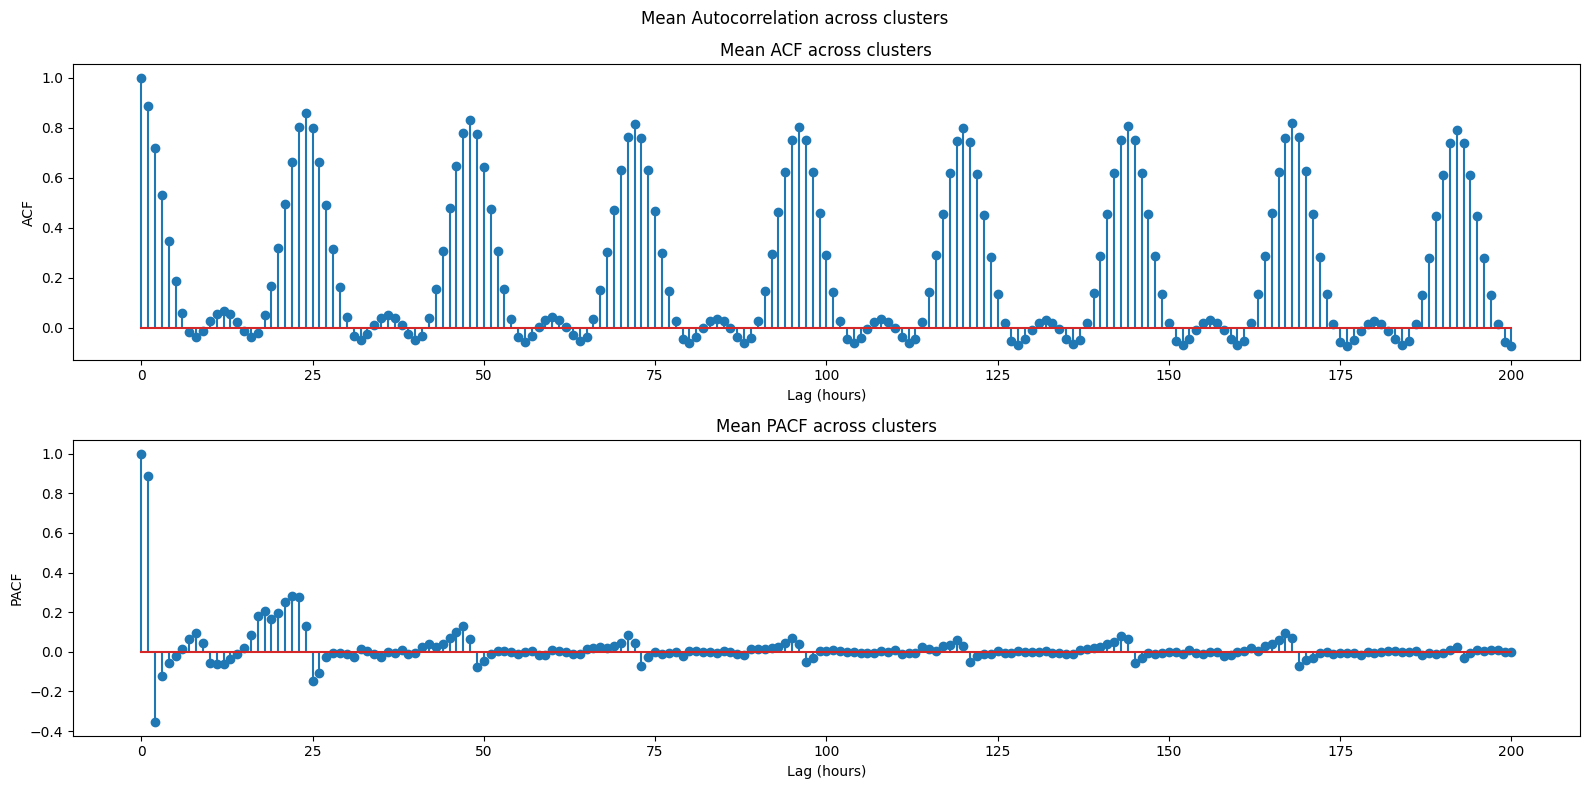

In [10]:
# ANALYSE THE AUTOCORRELATION TO IDENTIFY SEASONALITY

from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

n_lags = 200

cluster_ids = sorted(df_time_mean_cluster['cluster'].unique())
n_clusters = len(cluster_ids)

acf_arr = np.zeros((n_clusters, n_lags + 1))
pacf_arr = np.zeros((n_clusters, n_lags + 1))

for idx, cluster_id in enumerate(cluster_ids):

    _df = df_time_mean_cluster[df_time_mean_cluster['cluster'] == cluster_id]

    acf_arr[idx, :] = acf(_df['energy(kWh)'], nlags=n_lags)
    pacf_arr[idx, :] = pacf(_df['energy(kWh)'], nlags=n_lags)

# Mean acf/pacf between clusters for each lag
acf_mean = np.mean(acf_arr, axis=0)
pacf_mean = np.mean(pacf_arr, axis=0)


# Plot the mean autocorrelation of the samples
_lags = np.arange(len(acf_mean))

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# ACF mean
ax[0].stem(_lags, acf_mean,)
ax[0].set_title('Mean ACF across clusters')
ax[0].set_xlabel('Lag (hours)')
ax[0].set_ylabel('ACF')

# PACF mean
ax[1].stem(_lags, pacf_mean)
ax[1].set_title('Mean PACF across clusters')
ax[1].set_xlabel('Lag (hours)')
ax[1].set_ylabel('PACF')

plt.suptitle('Mean Autocorrelation across clusters')
plt.tight_layout()
plt.show()



In [11]:
# Analyse the daily max autocorrelation
__idx = range(0,n_lags+1,24)
acf_mean[__idx]

array([1.        , 0.85850875, 0.83202804, 0.81393606, 0.80403315,
       0.79744668, 0.80557162, 0.81804933, 0.79239326])

### Feature engineering and LAGS + Train/Test split (function)

Create new features for hour, dayofweek, month. Then turn them into sin/cos values to express the seasonality over the day, the week and the month, so that samples near the same time have similar values.

Let's define the following time angles for the sin() functions:

$\theta_{hour}=2\pi\,\frac{hour\,of\,day}{24}$

$\theta_{day}=2\pi\,\frac{day\,of\,week}{7}$

$\theta_{month}=2\pi\,\frac{month\,of\,year}{12}$

In [12]:
def feature_eng(df_time_mean_cluster: pd.DataFrame):
  '''Create a new dataframe with time features'''

  X_tot = df_time_mean_cluster.copy()
  # Create new features for hour, dayofweek, month
  X_tot['hour'] = X_tot['tstp'].dt.hour
  X_tot['dayofweek'] = X_tot['tstp'].dt.dayofweek
  X_tot['month'] = X_tot['tstp'].dt.month
  X_tot.drop(columns='tstp')

  # Turn the features into sin() values -> [also, in this way the values are normalized in (-1,+1)]
  X_tot['hour_sin'] = np.sin(2 * np.pi * X_tot['hour'] / 24)
  X_tot['day_sin'] = np.sin(2 * np.pi * X_tot['dayofweek'] / 7)
  X_tot['month_sin'] = np.sin(2 * np.pi * X_tot['month'] / 12)

  # Create lags to make methods like MLP have a memory and learn auto-correlation
  X_tot['lag_1'] = X_tot['energy(kWh)'].shift(1)
  X_tot['lag_24'] = X_tot['energy(kWh)'].shift(24)
  X_tot['lag_168'] = X_tot['energy(kWh)'].shift(168)

  # Remove unuseful/redundant features
  X_tot = X_tot.drop(columns=['hour', 'dayofweek', 'month'])

  # Convert 'tstp' to datetime
  X_tot['tstp'] = pd.to_datetime(X_tot['tstp'])

  # Set 'tstp' as index column
  X_tot = X_tot.set_index('tstp')

  # Remove NaN samples (first 168 rows), that have been created by the shifting
  return X_tot.dropna()



def train_test_split(df_time_mean_cluster: pd.DataFrame,
                     X_tot: pd.DataFrame,
                     cluster_id: int, train_ratio=0.7):
  '''Splits the time series into train and test sets'''

  # Filter the df taking only the samples with same cluster_id
  X_tot = X_tot[X_tot['cluster'] == cluster_id].copy()

  # Calc split indexes
  split_idx = int(len(X_tot) * train_ratio)

  # Train/Test dataset split
  X_tot_train = X_tot.iloc[:split_idx].astype(float)
  X_tot_test  = X_tot.iloc[split_idx:].astype(float)


  # Energy load time series
  y_train = X_tot_train['energy(kWh)']
  y_test = X_tot_test['energy(kWh)']

  # Features time series
  X_train = X_tot_train.drop(columns='energy(kWh)')
  X_test = X_tot_test.drop(columns='energy(kWh)')

  return y_train, y_test, X_train, X_test


In [13]:
# Check the total dataset after feature engineering
feature_eng(df_time_mean_cluster)

,cluster,energy(kWh),hour_sin,day_sin,month_sin,lag_1,lag_24,lag_168
tstp,,,,,,,,
2011-12-13 15:00:00,0,0.285000,-0.707107,0.781831,-2.449294e-16,0.167750,0.153333,0.127000
2011-12-13 16:00:00,0,0.262250,-0.866025,0.781831,-2.449294e-16,0.285000,0.308667,0.137000
2011-12-13 17:00:00,0,0.332750,-0.965926,0.781831,-2.449294e-16,0.262250,0.816667,0.540000
2011-12-13 18:00:00,0,0.479000,-1.000000,0.781831,-2.449294e-16,0.332750,0.858333,0.361000
2011-12-13 19:00:00,0,0.507500,-0.965926,0.781831,-2.449294e-16,0.479000,0.728667,0.400000
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,5,0.886685,-0.866025,0.433884,8.660254e-01,0.990164,0.926920,0.917304
2014-02-27 21:00:00,5,0.787728,-0.707107,0.433884,8.660254e-01,0.886685,0.844826,0.800098
2014-02-27 22:00:00,5,0.743634,-0.500000,0.433884,8.660254e-01,0.787728,0.724671,0.704902


In [14]:
# Def. a comprehensive function, in order to be able to rapidly change cluster_ID

# CALL THE JUST CREATED FUNCTIONS to split the dataset, extract features and choose 1 cluster_ID

def extract_and_split_data(df_time_mean_cluster,
                           cluster_id,
                           train_ratio=0.7,
                           verbose=True):

  K = max(df_time_mean_cluster['cluster'])

  if cluster_id > K:
    raise ValueError(f'Cluster ID must be between 0 and {K}')

  # Call the feature engineering
  X_tot = feature_eng(df_time_mean_cluster)

  # for cluster_id in range(K):
  y_train, y_test, X_train, X_test = train_test_split(df_time_mean_cluster,X_tot,
                                                        cluster_id, train_ratio=train_ratio)

  if verbose:
    # Check
    print(f"CLUSTER_ID CONSIDERED: {cluster_id}")
    print('-'*30)
    print(f"y_train length: {len(y_train)}")
    print(f"y_test length: {len(y_test)}")

  return y_train, y_test, X_train, X_test

### Scoring functions

In [15]:
# Define score functions
# msre, rmsre, mae, mape, rmspe
# -------------------------

def _to_numpy(y_forecast, y_test):
    """Convert inputs to numpy arrays."""
    return np.asarray(y_forecast, dtype=float), np.asarray(y_test, dtype=float)


# Relative Error Metrics

def msre(y_forecast, y_test):
    """
    Mean Squared Relative Error (MSRE)
    MSRE = mean(((y_pred - y_true) / y_true)^2)
    """
    y_pred, y_true = _to_numpy(y_forecast, y_test)
    return np.mean(((y_pred - y_true) / y_true) ** 2)


def rmsre(y_forecast, y_test):
    """
    Root Mean Squared Relative Error (RMSRE)
    RMSRE = sqrt(MSRE)
    """
    return np.sqrt(msre(y_forecast, y_test))


# Absolute Error Metrics

def mae(y_forecast, y_test):
    """
    Mean Absolute Error (MAE)
    MAE = mean(|y_pred - y_true|)
    """
    y_pred, y_true = _to_numpy(y_forecast, y_test)
    return np.mean(np.abs(y_pred - y_true))


def mare(y_forecast, y_test):
    """
    Mean Absolute Relative Error (MARE)
    MARE = mean(|y_pred - y_true| / |y_true|)
    """
    y_pred, y_true = _to_numpy(y_forecast, y_test)
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))


def mape(y_forecast, y_test):
    """
    Mean Absolute Percentage Error (MAPE)
    MAPE = 100 * mean(|(y_pred - y_true) / y_true|)
    """
    return 100 * mare(y_forecast, y_test)


def rmspe(y_forecast, y_test):
    """
    Root Mean Squared Percentage Error (RMSPE)
    RMSPE = 100 * sqrt(mean(((y_pred - y_true) / y_true)^2))
    """
    return 100 * rmsre(y_forecast, y_test)


### Cluster-level forecasting algorithms (functions)

In [16]:
# Utility plotting func

def show_test_results_func(model_name, cluster_id, y_train, y_test, _train_forecasts, test_forecasts,
                      perc_window_start, perc_window_end,
                      color_y_train, color_y_test, color_y_test_forecasts):
  '''Plot the results of the forecasting '''

  # --------------------------------------------------------
  # SCORE ON TRAIN: msre, rmsre, mae, mape, rmspe
  scores_train = {
      'msre': msre(_train_forecasts, y_train),
      'rmsre': rmsre(_train_forecasts, y_train),
      'mae': mae(_train_forecasts, y_train),
      'mape': mape(_train_forecasts, y_train),
      'rmspe': rmspe(_train_forecasts, y_train)
  }

  # SCORE ON TEST: msre, rmsre, mae, mape, rmspe
  scores_test = {
      'msre': msre(test_forecasts, y_test),
      'rmsre': rmsre(test_forecasts, y_test),
      'mae': mae(test_forecasts, y_test),
      'mape': mape(test_forecasts, y_test),
      'rmspe': rmspe(test_forecasts, y_test)
  }

  # Print the results
  print(f"SCORES ON TRAIN:\n")
  for k, v in scores_train.items():
    print(f"{k}\t{round(v,3)}")
  print('-'*30)
  print(f"SCORES ON TEST:\n")
  for k, v in scores_test.items():
    print(f"{k}\t{round(v,3)}")


  # PLOT THE RESULTS
  plt.figure(figsize=(10,5))
  plt.subplot(3,1,1)
  plt.plot(y_train.index, y_train, label='Train data', color=color_y_train)
  plt.plot(y_test.index, y_test, label='Test data', color=color_y_test)
  plt.plot(y_test.index, test_forecasts, label='Forecast on test', color=color_y_test_forecasts)
  plt.ylabel('Energy (kWh)')
  plt.legend()

  plt.subplot(3,1,2)
  plt.plot(y_test.index, y_test, label='Test data', color=color_y_test)
  plt.plot(y_test.index, test_forecasts, label='Forecast on test', color=color_y_test_forecasts)
  plt.ylabel('Energy (kWh)')
  plt.legend()
  # Analyse a shorter window of time
  plt.subplot(3,1,3)
  _idx_start = int(len(y_test)*perc_window_start)
  _idx_end = int(len(y_test)*perc_window_end)
  plt.plot(y_test.index[_idx_start:_idx_end], y_test[_idx_start:_idx_end], label='Test data', color=color_y_test)
  plt.plot(y_test.index[_idx_start:_idx_end], test_forecasts[_idx_start:_idx_end], label='Forecast on test', color=color_y_test_forecasts)
  plt.ylabel('Energy (kWh)')
  plt.legend()

  plt.xlabel('Time')
  # title subplot
  plt.suptitle(f'{model_name} - Cluster ID: {cluster_id}')
  plt.show()

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# ARIMA ---------------------------------------------------

def ARIMA_func(y_train, y_test, cluster_id, order=(2,1,2),
               show_test_results=True,
               perc_window_start=0.4, perc_window_end=0.6):
  '''Train and test the ARIMA model (AutoRegressive Integrated Moving Average)'''

  # ARIMA model
  model_arima = ARIMA(y_train, order=order)
  # model_arima = SARIMAX(y_train,order=(1,1,1),seasonal_order=(1,1,1,24)) # <- TODO: try to use SARIMA (?)

  # fit the model
  model_arima_fit = model_arima.fit()

  # forecast on train (to assess bias and overfitting)
  _train_forecasts_arima = model_arima_fit.forecast(steps=len(y_train))
  _train_forecasts_arima = np.array(_train_forecasts_arima)

  # forecast on test
  test_forecasts_arima = model_arima_fit.forecast(steps=len(y_test))
  test_forecasts_arima = np.array(test_forecasts_arima)

  # Show the results
  if show_test_results:
    show_test_results_func(model_name='ARIMA', cluster_id=cluster_id,
                           y_train=y_train, y_test=y_test, _train_forecasts=_train_forecasts_arima,
                           test_forecasts=test_forecasts_arima,
                           perc_window_start=perc_window_start, perc_window_end=perc_window_end,
                           color_y_train='blue',
                           color_y_test='black',
                           color_y_test_forecasts='red')

  return test_forecasts_arima



# Decision Tree ---------------------------------------------------

def DT_func(y_train, y_test, X_train, X_test, cluster_id,
            show_test_results=True,
            perc_window_start=0.4, perc_window_end=0.6):
  '''Train and test the Decision Tree regressor model'''

  tree = DecisionTreeRegressor(max_depth=5, random_state=0)
  tree.fit(X_train, y_train)

  # Predict train data
  _train_forecasts = tree.predict(X_train)

  # Predict test data
  test_forecasts = tree.predict(X_test)

  # Training
  tree.fit(X_train, y_train)

  # Predictions on the train set
  _train_forecasts = tree.predict(X_train)
  # Predictions on the test set
  test_forecasts = tree.predict(X_test)

  # Show the results
  if show_test_results:
    show_test_results_func(model_name='Decistion Tree', cluster_id=cluster_id,
                           y_train=y_train, y_test=y_test,
                           _train_forecasts=_train_forecasts, test_forecasts=test_forecasts,
                           perc_window_start=perc_window_start, perc_window_end=perc_window_end,
                           color_y_train='blue',
                           color_y_test='black',
                           color_y_test_forecasts='red')

  return test_forecasts



# MLP ---------------------------------------------------

def MLP_func(y_train, y_test, X_train, X_test, cluster_id,
              show_test_results=True,
              perc_window_start=0.4, perc_window_end=0.6):
  '''Train and test the MLP NN Regressor model (Multi-Layer Perceptron)'''

  mlp = MLPRegressor(
      hidden_layer_sizes=(32, 16),
      activation='relu',
      solver='adam',
      max_iter=500,
      random_state=42)

  # Training
  mlp.fit(X_train, y_train)

  # Predictions on the train set
  _train_forecasts = mlp.predict(X_train)
  # Predictions on the test set
  test_forecasts = mlp.predict(X_test)

  # Show the results
  if show_test_results:
    show_test_results_func(model_name='MLP', cluster_id=cluster_id,
                           y_train=y_train, y_test=y_test,
                           _train_forecasts=_train_forecasts, test_forecasts=test_forecasts,
                           perc_window_start=perc_window_start, perc_window_end=perc_window_end,
                           color_y_train='blue',
                           color_y_test='black',
                           color_y_test_forecasts='red')

  return test_forecasts


In [17]:
# CHOOSE THE CLUSTER_ID
cluster_id = 0

# CALL THE FUNCTION TO PREPARE THE DATASET, SELECT THE CLUSTER_ID AND SPLIT THE DATA
y_train, y_test, X_train, X_test = extract_and_split_data(df_time_mean_cluster,
                                                          cluster_id=cluster_id,
                                                          train_ratio=0.7,
                                                          verbose=True)

CLUSTER_ID CONSIDERED: 0
------------------------------
y_train length: 13564
y_test length: 5814


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SCORES ON TRAIN:

msre	0.163
rmsre	0.404
mae	0.081
mape	32.18
rmspe	40.362
------------------------------
SCORES ON TEST:

msre	0.149
rmsre	0.386
mae	0.076
mape	31.165
rmspe	38.61


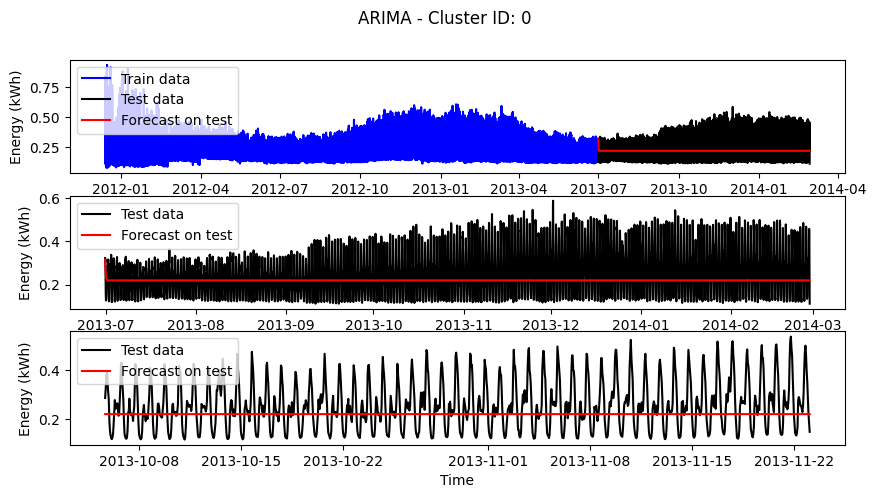

In [20]:
# ARIMA METHOD
order = (1,1,2)
test_forecasts_arima = ARIMA_func(y_train, y_test,
                                  cluster_id,
                                  order=order,
                                  show_test_results=True,
                                  perc_window_start=0.4,
                                  perc_window_end=0.6) # EXPERIMETS: order (2,1,2) - (1,1,1)


SCORES ON TRAIN:

msre	0.018
rmsre	0.133
mae	0.024
mape	9.193
rmspe	13.257
------------------------------
SCORES ON TEST:

msre	0.009
rmsre	0.093
mae	0.018
mape	7.175
rmspe	9.314


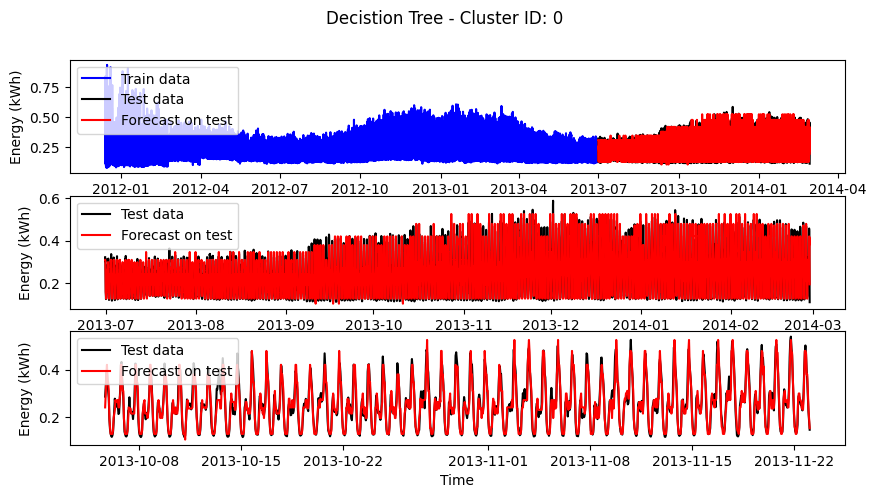

array([0.30974316, 0.30974316, 0.30974316, ..., 0.41298847, 0.30974316,
       0.19513155])

In [23]:
# DECISION TREE METHOD
DT_func(y_train, y_test, X_train, X_test, cluster_id,
        show_test_results=True,
        perc_window_start=0.4, perc_window_end=0.6)

SCORES ON TRAIN:

msre	0.015
rmsre	0.122
mae	0.022
mape	8.564
rmspe	12.158
------------------------------
SCORES ON TEST:

msre	0.008
rmsre	0.088
mae	0.017
mape	6.893
rmspe	8.831


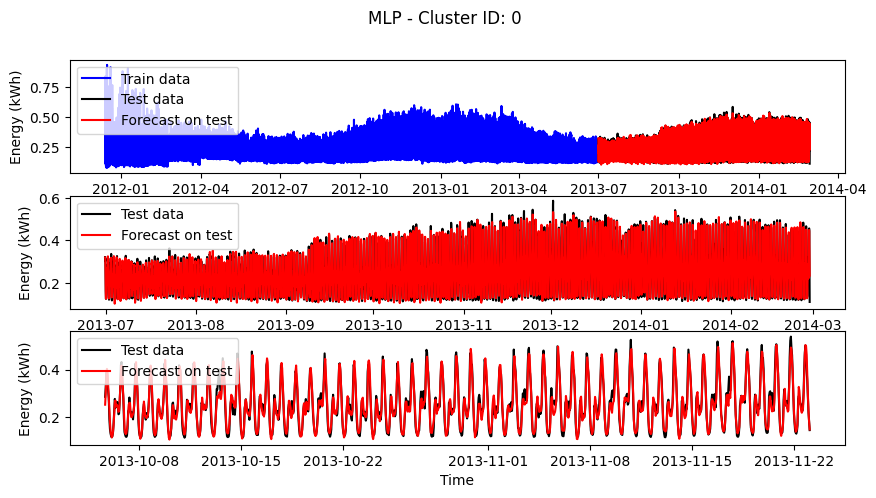

In [21]:
# MLP METHOD
test_forecasts_mlp = MLP_func(y_train, y_test, X_train, X_test, cluster_id,
                              show_test_results=True,
                              perc_window_start=0.4, perc_window_end=0.6)


# ILF: Individual Load Forecasting (with NN)

We previously forecasted the hourly electric load in a cluster level, representing on average all the households beloging in that cluster.

GOAL: now we want to split the hoourly load forecasts among each household (LCLid) in a specific cluster.